# HW6:
Time so far: 1

## Problem 1

In [ ]:
!pip install cartopy
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.stats as stats
import scipy.signal as sig
import statsmodels.api as sm
import sklearn.linear_model as lm
from sklearn.impute import SimpleImputer
import cartopy.crs as ccrs

In [2]:
data = xr.open_dataset('/content/drive/MyDrive/Classes/OA/HW6/BEST-1950-2018-monthlyTemp_4x4.nc')
data

<xarray.Dataset> Size: 14MB
Dimensions:      (time: 828, lon: 90, lat: 45, month_number: 12)
Coordinates:
  * time         (time) datetime64[ns] 7kB 1950-01-31 1950-02-28 ... 2018-12-31
  * lon          (lon) float64 720B 0.0 4.0 8.0 12.0 ... 344.0 348.0 352.0 356.0
  * lat          (lat) float64 360B -90.0 -85.91 -81.82 ... 81.82 85.91 90.0
Dimensions without coordinates: month_number
Data variables:
    land_mask    (lat, lon) float64 32kB ...
    temperature  (time, lat, lon) float32 13MB ...
    climatology  (month_number, lat, lon) float32 194kB ...
Attributes:
    CDI:                   Climate Data Interface version 1.9.8 (https://mpim...
    history:               Wed Mar 25 12:39:01 2020: cdo remapcon,r90x45 ../h...
    institution:           Berkeley Earth Surface Temperature Project
    Conventions:           Berkeley Earth Internal Convention (based on CF-1.5)
    title:                 Native Format Berkeley Earth Surface Temperature A...
    land_source_history:   15-Feb-2019 05:32:39
    ocean_source_history:  18-Feb-2019 16:21:50
    comment:               This file contains Berkeley Earth surface temperat...
    CDO:                   Climate Data Operators version 1.9.8 (https://mpim...

In [9]:
T = data.temperature
T

<xarray.DataArray 'temperature' (time: 828, lat: 45, lon: 90)> Size: 13MB
array([[[          nan,           nan, ...,           nan,           nan],
        [          nan,           nan, ...,           nan,           nan],
        ...,
        [ 1.897326e-01,  1.943860e-01, ...,  1.782967e-01,  1.843934e-01],
        [ 1.572238e-16,  1.580909e-16, ...,  1.544986e-16,  1.559102e-16]],

       [[          nan,           nan, ...,           nan,           nan],
        [          nan,           nan, ...,           nan,           nan],
        ...,
        [ 1.841493e-02,  1.974825e-02, ...,  1.481318e-02,  1.666771e-02],
        [-6.143775e-17, -6.170176e-17, ..., -6.104457e-17, -6.120087e-17]],

       ...,

       [[ 1.651898e-17,  1.579418e-17, ...,  1.799192e-17,  1.725269e-17],
        [ 1.662458e-02,  1.381659e-02, ...,  2.223322e-02,  1.941101e-02],
        ...,
        [ 1.488976e-01,  1.561130e-01, ...,  1.350755e-01,  1.418064e-01],
        [ 1.640185e-16,  1.657565e-16, ...,  1.604009e-16,  1.622722e-16]],

       [[ 2.153156e-16,  2.151993e-16, ...,  2.154661e-16,  2.154012e-16],
        [ 2.233372e-01,  2.222237e-01, ...,  2.257394e-01,  2.245932e-01],
        ...,
        [ 2.021407e-01,  2.075980e-01, ...,  1.932306e-01,  1.975705e-01],
        [ 2.099358e-16,  2.107813e-16, ...,  2.067263e-16,  2.086404e-16]]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 7kB 1950-01-31 1950-02-28 ... 2018-12-31
  * lon      (lon) float64 720B 0.0 4.0 8.0 12.0 ... 344.0 348.0 352.0 356.0
  * lat      (lat) float64 360B -90.0 -85.91 -81.82 -77.73 ... 81.82 85.91 90.0
Attributes:
    standard_name:  surface_temperature_anomaly
    long_name:      Air Surface Temperature Anomaly
    units:          degree C

In [162]:
# what percent of values are missing?
(np.size(T) - np.count_nonzero(~np.isnan(T)))/(np.size(T)) * 100

0.681964573268921

In [179]:
T = T.dropna('time')

In [283]:
T.max()

<xarray.DataArray 'temperature' ()> Size: 8B
array(5.12777138)

### (a) Calculate the EOFs.
Did you standardize your data? No.

In [184]:
# weight by latitude
T_array = T.values

for i, lat in enumerate(T.lat.values):
  T_array[:, i, :] = T_array[:, i, :] * np.cos(np.deg2rad(lat))

# flatten
T_f = T_array.reshape(700, -1)

In [186]:
# get the covariance matrix
C = 1./np.size(T_f, axis = 0)*(np.dot(np.transpose(T_f), T_f)) # spatial by spatial

In [187]:
np.shape(C)

(4050, 4050)

In [188]:
# compute the eigenvalues and eigenvectors
lam, E = np.linalg.eig(C)

In [216]:
# sort eigenvalues and vector by the largest to smallest eigenvalues
i = np.flipud(np.argsort(lam))
lam = lam[i]
E = E[:, i]

### (b) Plot the eigenvalues with error bars.
How did you determine Neff?

### Calculate N* using Bretherton et al.

In [197]:
# calculate linear trend
slopes = np.zeros((len(data.lat), len(data.lon)))
for i, lat in enumerate(data.lat):
    for j, lon in enumerate(data.lon):
        d = T.isel(lat=i).isel(lon=j)
        X = np.arange(len(d.time)).reshape(-1, 1)
        y = d.values.reshape(-1, 1)
        linreg = lm.LinearRegression().fit(X, y)
        slopes[i][j] = linreg.coef_[0][0]
slopes = xr.DataArray(slopes, dims=['lat', 'lon'], coords={'lat': data.lat, 'lon': data.lon})

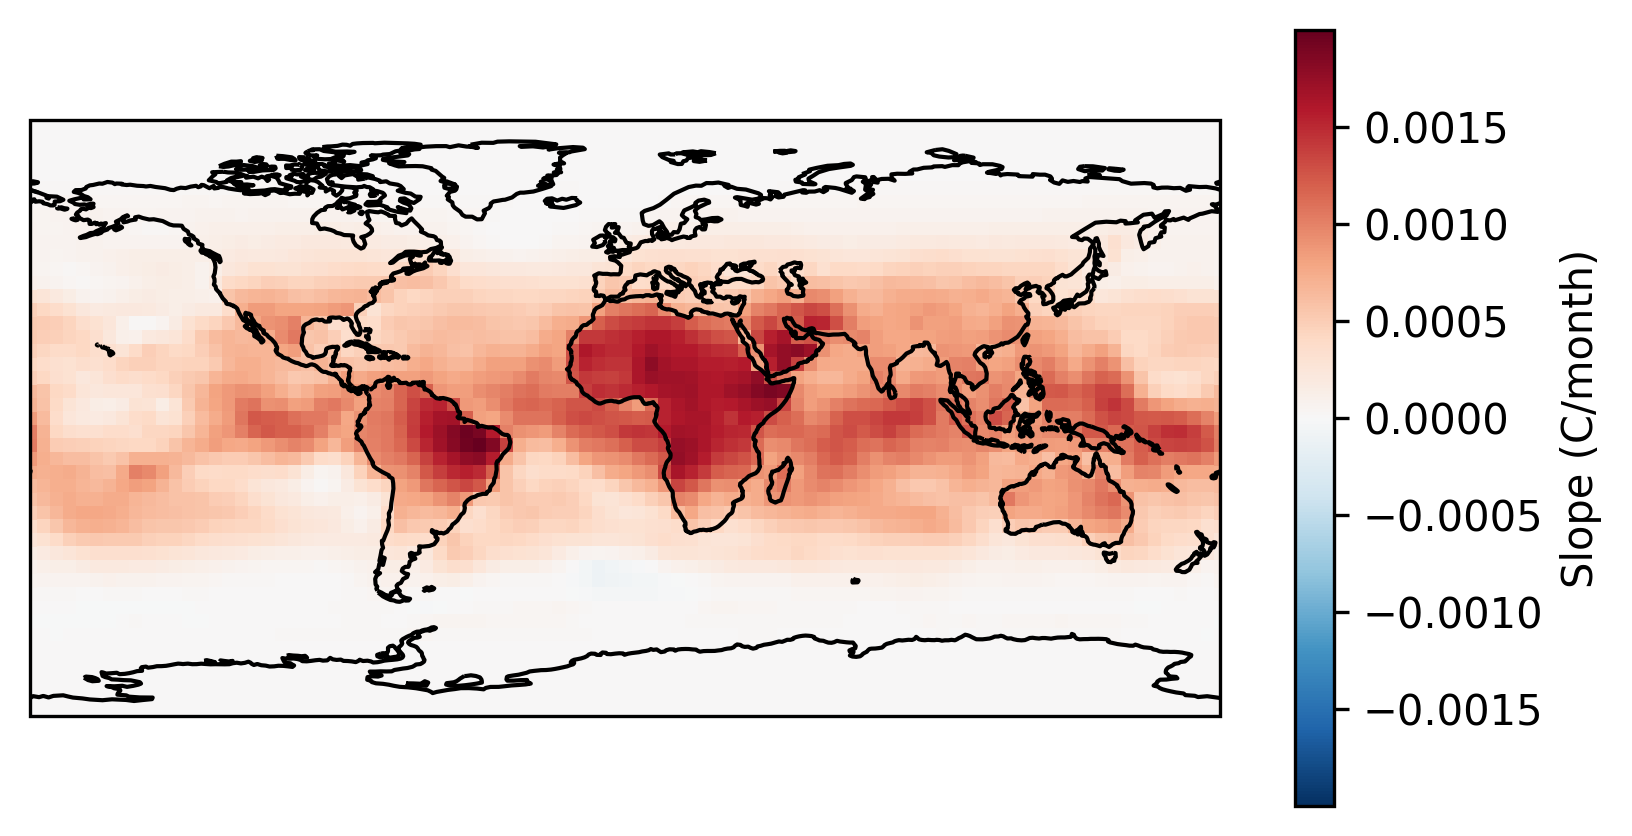

In [290]:
# plot on map
fig, ax = plt.subplots(1,1, dpi=300, subplot_kw=dict(projection=ccrs.PlateCarree()))
im = slopes.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
cbar = plt.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label('Slope (C/month)')
ax.coastlines();

In [199]:
# remove linear trend
T2 = T - slopes*T.time

In [295]:
T.time

<xarray.DataArray 'time' (time: 700)> Size: 6kB
array([ 73,  74,  75, ..., 825, 826, 827])
Coordinates:
  * time     (time) int64 6kB 73 74 75 80 81 82 83 ... 822 823 824 825 826 827

In [200]:
# get autocorrelation dataset for all gridpts
def get_rhos(data):
    rhos = np.empty((len(data.lat), len(data.lon)))

    stan = (data - data.mean(dim='time'))/data.std(dim='time', ddof=1) # standardize data
    for j, lat in enumerate(stan.lat):
        for i, lon in enumerate(stan.lon):
            rhos[j][i] = sm.tsa.acf(stan.sel(lat=lat).sel(lon=lon))[1]
    return xr.DataArray(rhos, dims=['lat', 'lon'], coords={'lat': data.lat, 'lon': data.lon})

In [291]:
np.shape(T)

(700, 45, 90)

In [201]:
rho_ds = get_rhos(T2)

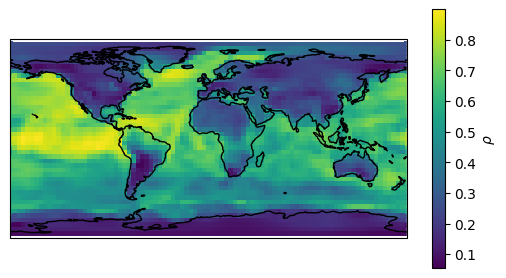

In [286]:
# plot on map
fig, ax = plt.subplots(1,1, dpi=100, subplot_kw=dict(projection=ccrs.PlateCarree()))
im = rho_ds.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
cbar = plt.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label('$\\rho$')
ax.coastlines();

In [299]:
rho_ds.median()

<xarray.DataArray ()> Size: 8B
array(0.46670629)

In [296]:
Nstar = np.size(T, axis=0)*(1-rho_ds.median()**2)/(1+rho_ds.median()**2)
Nstar

<xarray.DataArray ()> Size: 8B
array(449.60012527)

In [297]:
# convert eigenvalues to percent variance explained
pve = 100.0 * lam / np.sum(lam)

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:3413: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


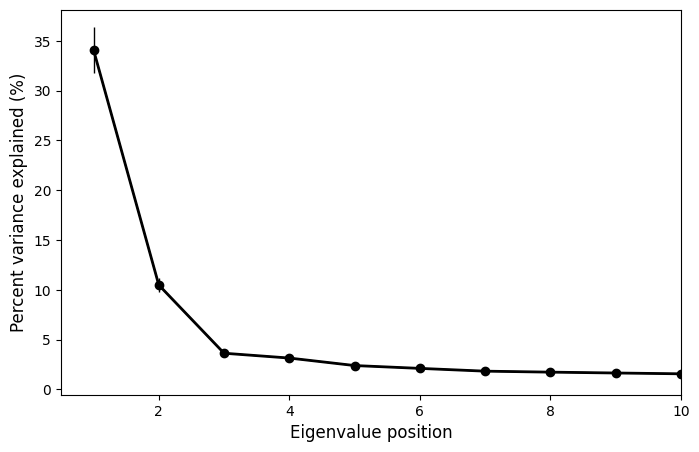

In [298]:
plt.figure(figsize=(8, 5), dpi=100)
plt.plot(np.arange(1, np.size(pve[:11]) + 1.0), pve[:11], "o-", linewidth=2, color="black")

plt.xlim(0.5, 10)
plt.xlabel("Eigenvalue position", fontsize=12)
plt.ylabel("Percent variance explained (%)", fontsize=12)

# plot error bars according to North et al.abs
eb = pve[:11] * np.sqrt(2.0 / Nstar.values)
plt.errorbar(
    np.arange(1, np.size(pve[:11]) + 1.0),
    pve[:11],
    yerr=eb,
    xerr=None,
    linewidth=1,
    color="black",
)

plt.show();

### (c) Compute the leading two EOF patterns and PCs

In [274]:
E1 = E[:, 0] # shape: 4050,
E2 = E[:, 1]

In [275]:
# reshape and drop complex part
E1_buf = np.real(E1.reshape(len(data.lat), len(data.lon)))
E2_buf = np.real(E2.reshape(len(data.lat), len(data.lon)))

# convert to dataset
E1_ds = xr.DataArray(E1_buf, dims=['lat', 'lon'], coords={'lat': data.lat, 'lon': data.lon})
E2_ds = xr.DataArray(E2_buf, dims=['lat', 'lon'], coords={'lat': data.lat, 'lon': data.lon})

In [266]:
# compute the two leading PC timeseries
PC1 = np.dot(T_f, E1)
PC2 = np.dot(T_f, E2)

### (d) Plot the 2 leading EOF patterns and 2 PCs

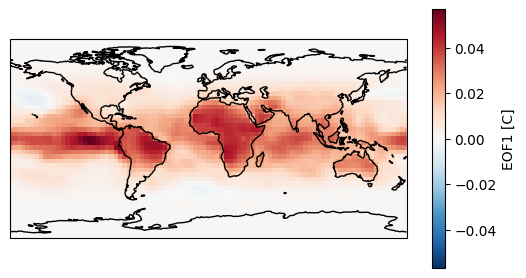

In [287]:
# plot on map
fig, ax = plt.subplots(1,1, dpi=100, subplot_kw=dict(projection=ccrs.PlateCarree()))
im = E1_ds.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
cbar = plt.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label('EOF1 [C]')
ax.coastlines();

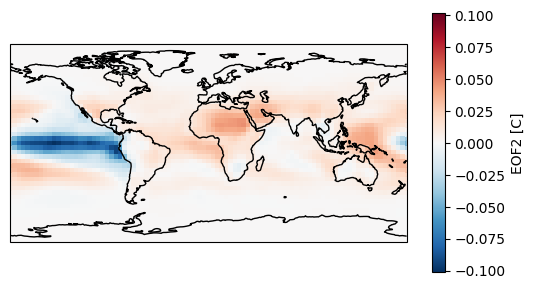

In [288]:
# plot on map
fig, ax = plt.subplots(1,1, dpi=100, subplot_kw=dict(projection=ccrs.PlateCarree()))
im = E2_ds.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
cbar = plt.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label('EOF2 [C]')
ax.coastlines();

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


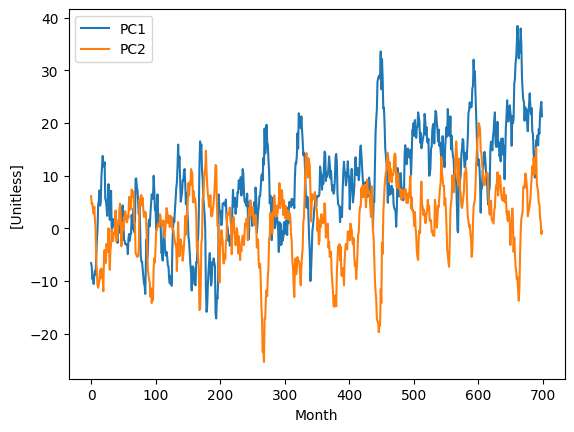

In [289]:
# plot the PC timeseries
months = np.arange(700)
fig, ax = plt.subplots(dpi=100)
ax.plot(months, PC1)
ax.plot(months, PC2)
ax.set_xlabel('Month')
ax.set_ylabel('[Unitless]')
ax.legend(['PC1', 'PC2'])
plt.show()